In [71]:
import fastai; fastai.__version__
from fastai.vision import *
import sys; sys.path.append("../dev")

In [75]:
PATH = Path("/home/turgutluk/data/breast_path/")

In [51]:
EXPORT_PATH = Path("/home/turgutluk/git/fast-kaggle/breast_path/experiment_exports/")

In [52]:
EXPORT_PATH.ls()

[PosixPath('/home/turgutluk/git/fast-kaggle/breast_path/experiment_exports/experiment1')]

In [53]:
EXPERIMENT = EXPORT_PATH/'experiment1'

In [54]:
EXPERIMENT.ls()

[PosixPath('/home/turgutluk/git/fast-kaggle/breast_path/experiment_exports/experiment1/training_log.csv'),
 PosixPath('/home/turgutluk/git/fast-kaggle/breast_path/experiment_exports/experiment1/Test_raw_preds.pkl'),
 PosixPath('/home/turgutluk/git/fast-kaggle/breast_path/experiment_exports/experiment1/Valid_raw_preds.pkl'),
 PosixPath('/home/turgutluk/git/fast-kaggle/breast_path/experiment_exports/experiment1/cli_log.json'),
 PosixPath('/home/turgutluk/git/fast-kaggle/breast_path/experiment_exports/experiment1/models')]

### logs

In [55]:
training_log = pd.read_csv(EXPERIMENT/'training_log.csv')

In [56]:
training_log.tail()

epoch train_loss valid_loss      dice   time
27     5   0.359347   0.255548  0.928630  00:02
28     6   0.360962   0.208037  0.944005  00:03
29     7   0.360786   0.302827  0.913759  00:02
30     8   0.359175   0.241255  0.942511  00:02
31     9   0.355424   0.237765  0.936451  00:02

### cli logs

In [57]:
import json
clilogs = json.loads(open(EXPERIMENT/'cli_log.json').read())[-1]

In [58]:
clilogs['time']

'09/21/2019, 16:35:22'

In [59]:
clilogs['command']

['python',
 '/home/turgutluk/git/fast-kaggle/dev/segmentation_training.py',
 '--PATH=/home/turgutluk/data/breast_path',
 '--IMAGES=images',
 '--MASKS=labels',
 '--CODES=codes.txt',
 '--TRAIN=train.txt',
 '--VALID=0.3',
 '--TEST=test.txt',
 '--suffix=.tif',
 '--bs=4',
 '--size=320',
 '--imagenet_pretrained=1',
 '--max_lr=0.001',
 '--model_name=bestmodel',
 '--epochs=10',
 '--tracking_metric=dice',
 '--void_name=Void',
 '--loss_function=crossent',
 '--opt=radam',
 '--EXPORT_PATH=./experiment_exports/experiment1']

In [60]:
print(clilogs['stdout'])

To use this log_lamb_rs, please run 'pip install tensorboardx'. Also you must have Tensorboard running to see results
Print args here: 
Training with arch: <function resnet34 at 0x7f6c85742268>
Tracking metric: <function dice at 0x7f6b8de2a8c8>
Training with loss: FlattenedLoss of CrossEntropyLoss()
Starting training with max_lr: 0.001
Training with transfer learning
epoch     train_loss  valid_loss  dice      time    
Initializing self.best
0         0.737229    0.771604    0.363651  00:10     
Better model found at epoch 0 with dice value: 0.3636508584022522.
1         0.680170    0.529058    0.812091  00:02     
Better model found at epoch 1 with dice value: 0.8120908737182617.
2         0.766911    0.619803    0.615364  00:02     
3         0.701971    0.523570    0.799238  00:02     
4         0.649700    0.596152    0.624633  00:02     
5         0.605367    0.357973    0.864184  00:02     
Better model found at epoch 5 with dice value: 0.8641838431358337.
6         0.579607    0

### models

In [61]:
(EXPERIMENT/'models').ls()

[PosixPath('/home/turgutluk/git/fast-kaggle/breast_path/experiment_exports/experiment1/models/bestmodel.pth')]

### valid preds (optional post process)

In [74]:
from local.segmentation.dataset import SemanticSegmentationData as ssdata

In [62]:
valid_preds = torch.load(EXPERIMENT/'Valid_raw_preds.pkl')

In [63]:
valid_preds.keys()

dict_keys(['fnames', 'preds', 'targs'])

In [64]:
fnames = valid_preds['fnames']
valpreds = valid_preds['preds']
valtargs = valid_preds['targs']

In [82]:
# get original labels
original_labels = [open_mask(ssdata.get_y_fn(PATH/'labels', '.tif', o)) for o in fnames]

In [102]:
# get original images
original_images = [open_image(o) for o in fnames]

In [93]:
# argmax preds 
argmax_preds = valpreds.argmax(1).unsqueeze(1); argmax_preds.shape

torch.Size([7, 1, 320, 320])

In [100]:
valtargs[0].shape

torch.Size([1, 320, 320])

In [96]:
argmax_preds[0].shape

torch.Size([1, 320, 320])

In [113]:
axes

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fec4774bc88>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7fec475606a0>]], dtype=object)

In [122]:
def _plot_val(n):
    "plot"
    fig, axes = plt.subplots(n,4, figsize=(4*10,n*10))
    for i, ax in zip(range(n), axes):
        # original image
        original_images[i].show(figsize=(5,5), ax=ax[0]); ax[0].set_title("SHG")
        # original label
        original_labels[i].show(figsize=(5,5), ax=ax[1], cmap='gray', alpha=1.); ax[1].set_title("Original Label")
        # resized label - downscaled to (320,320)
        ImageSegment(valtargs[i]).show(figsize=(5,5), ax=ax[2], cmap='gray', alpha=1.); ax[2].set_title("Downscaled Label (320,320)")
        # argmax pred
        ImageSegment(argmax_preds[i]).show(figsize=(5,5), ax=ax[3], cmap='gray', alpha=1.); ax[3].set_title("Argmax Pred");
    return fig

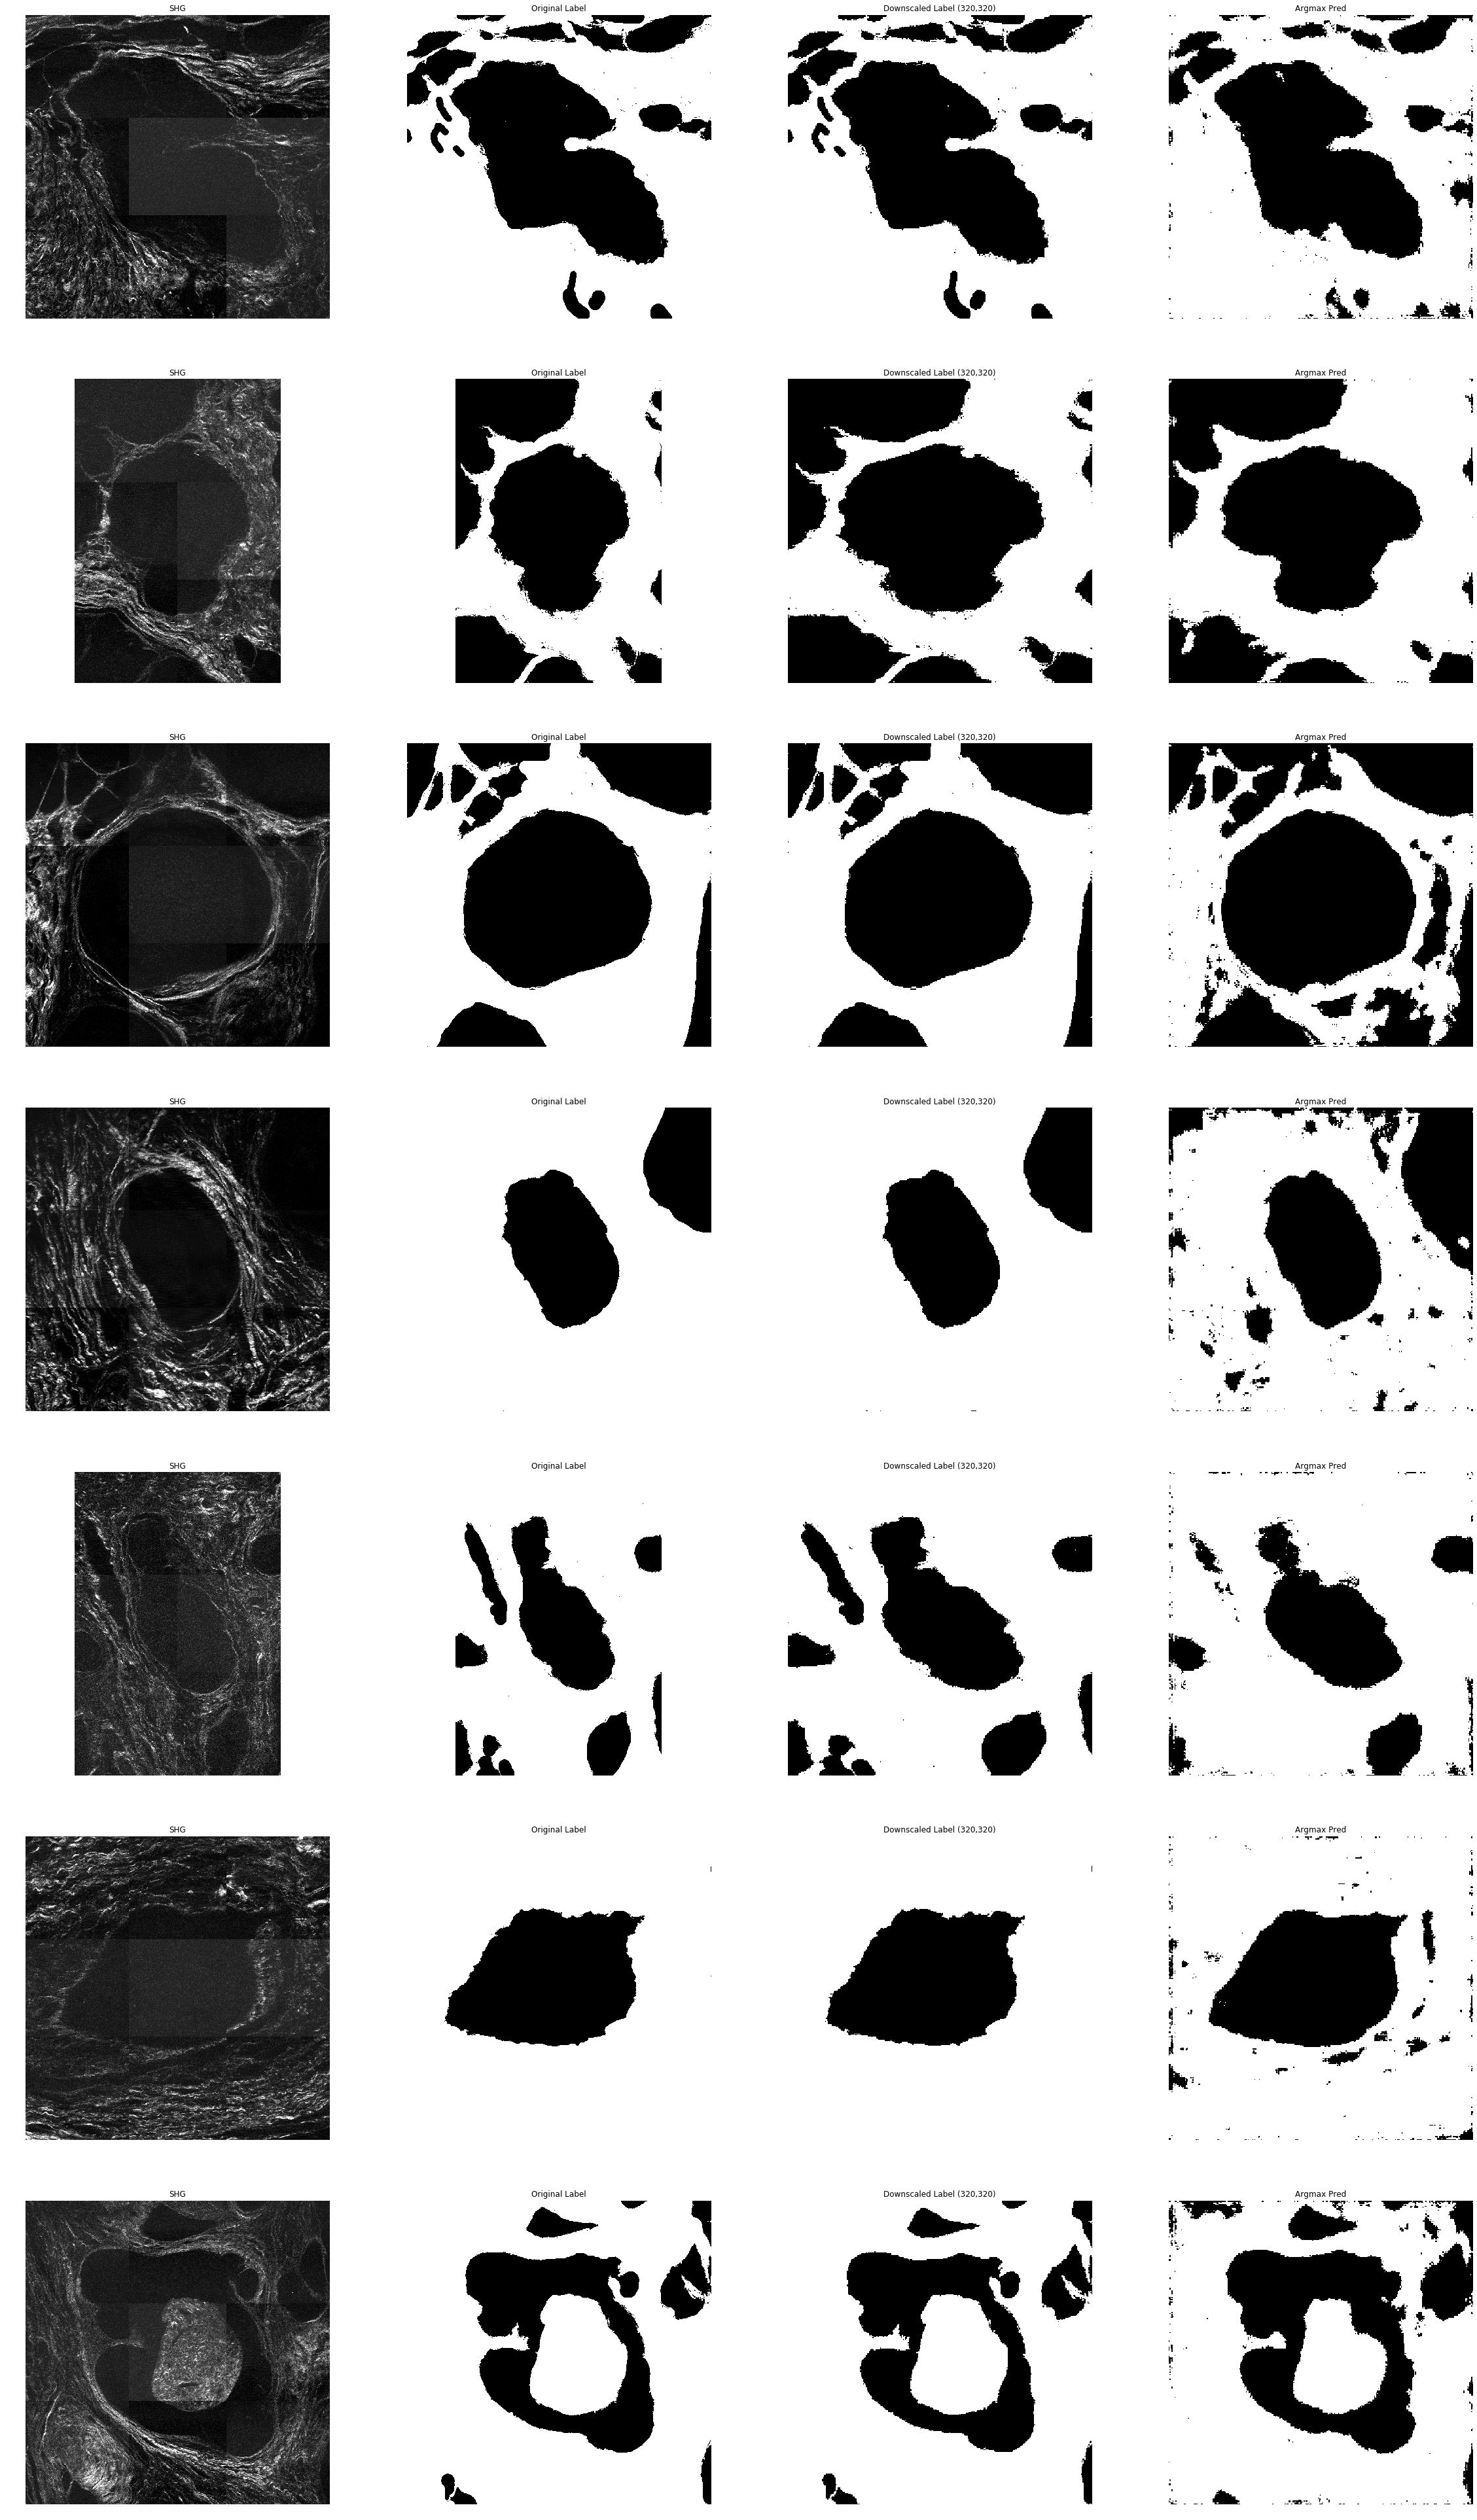

In [123]:
fig = _plot_val(len(fnames))

In [127]:
IMGPATH = EXPERIMENT/"valid_results.png"
fig.savefig(IMGPATH)

In [128]:
from IPython.display import FileLink

In [129]:
FileLink(IMGPATH)

/home/turgutluk/git/fast-kaggle/breast_path/experiment_exports/experiment1/valid_results.png

### test results - final evaluation

In [159]:
from local.segmentation.metrics import *

In [130]:
test_preds = torch.load(EXPERIMENT/'Test_raw_preds.pkl')

In [132]:
test_preds.keys()

dict_keys(['fnames', 'preds', 'targs'])

In [133]:
fnames = test_preds['fnames']
valpreds = test_preds['preds']
valtargs = test_preds['targs']

In [134]:
# get original labels
original_labels = [open_mask(ssdata.get_y_fn(PATH/'labels', '.tif', o)) for o in fnames]

In [135]:
# get original images
original_images = [open_image(o) for o in fnames]

In [136]:
# argmax preds 
argmax_preds = valpreds.argmax(1).unsqueeze(1); argmax_preds.shape

torch.Size([5, 1, 320, 320])

In [137]:
original_labels

[ImageSegment (1, 1517, 1148),
 ImageSegment (1, 1517, 1517),
 ImageSegment (1, 2255, 1517),
 ImageSegment (1, 1148, 1886),
 ImageSegment (1, 1517, 1148)]

In [166]:
upsampled_argmax_preds = []
for o, t in zip(original_labels, argmax_preds):
    _new = F.interpolate(t[None,...].float(), size=o.size, mode='nearest')[0]
    _new = ImageSegment(_new)
    assert _new.size == o.size
    upsampled_argmax_preds.append(_new)

In [169]:
original_labels, upsampled_argmax_preds

([ImageSegment (1, 1517, 1148),
  ImageSegment (1, 1517, 1517),
  ImageSegment (1, 2255, 1517),
  ImageSegment (1, 1148, 1886),
  ImageSegment (1, 1517, 1148)],
 [ImageSegment (1, 1517, 1148),
  ImageSegment (1, 1517, 1517),
  ImageSegment (1, 2255, 1517),
  ImageSegment (1, 1148, 1886),
  ImageSegment (1, 1517, 1148)])

In [179]:
def _dice(input:Tensor, targs:Tensor, iou:bool=False, eps:float=1e-8)->Rank0Tensor:
    "Dice coefficient metric for binary target. If iou=True, returns iou metric, classic for segmentation problems."
    n = targs.shape[0]
    input = input.view(n,-1)
    targs = targs.view(n,-1)
    intersect = (input * targs).sum(dim=1).float()
    union = (input+targs).sum(dim=1).float()
    if not iou: l = 2. * intersect / union
    else: l = intersect / (union-intersect+eps)
    l[union == 0.] = 1.
    return l.mean()

In [182]:
[_dice(original_labels[i].data, upsampled_argmax_preds[i].data) for i in range(len(fnames))]

[tensor(0.9457),
 tensor(0.9079),
 tensor(0.9205),
 tensor(0.9452),
 tensor(0.9275)]

In [174]:
def _plot_test(n):
    "plot"
    fig, axes = plt.subplots(n,3, figsize=(3*10,n*10))
    for i, ax in zip(range(n), axes):
        # original image
        original_images[i].show(figsize=(5,5), ax=ax[0]); ax[0].set_title("SHG")
        # original label
        original_labels[i].show(figsize=(5,5), ax=ax[1], cmap='gray', alpha=1.); ax[1].set_title("Original Label")
        # final pred
        upsampled_argmax_preds[i].show(figsize=(5,5), ax=ax[2], cmap='gray', alpha=1.); ax[2].set_title("Final Pred")
    return fig

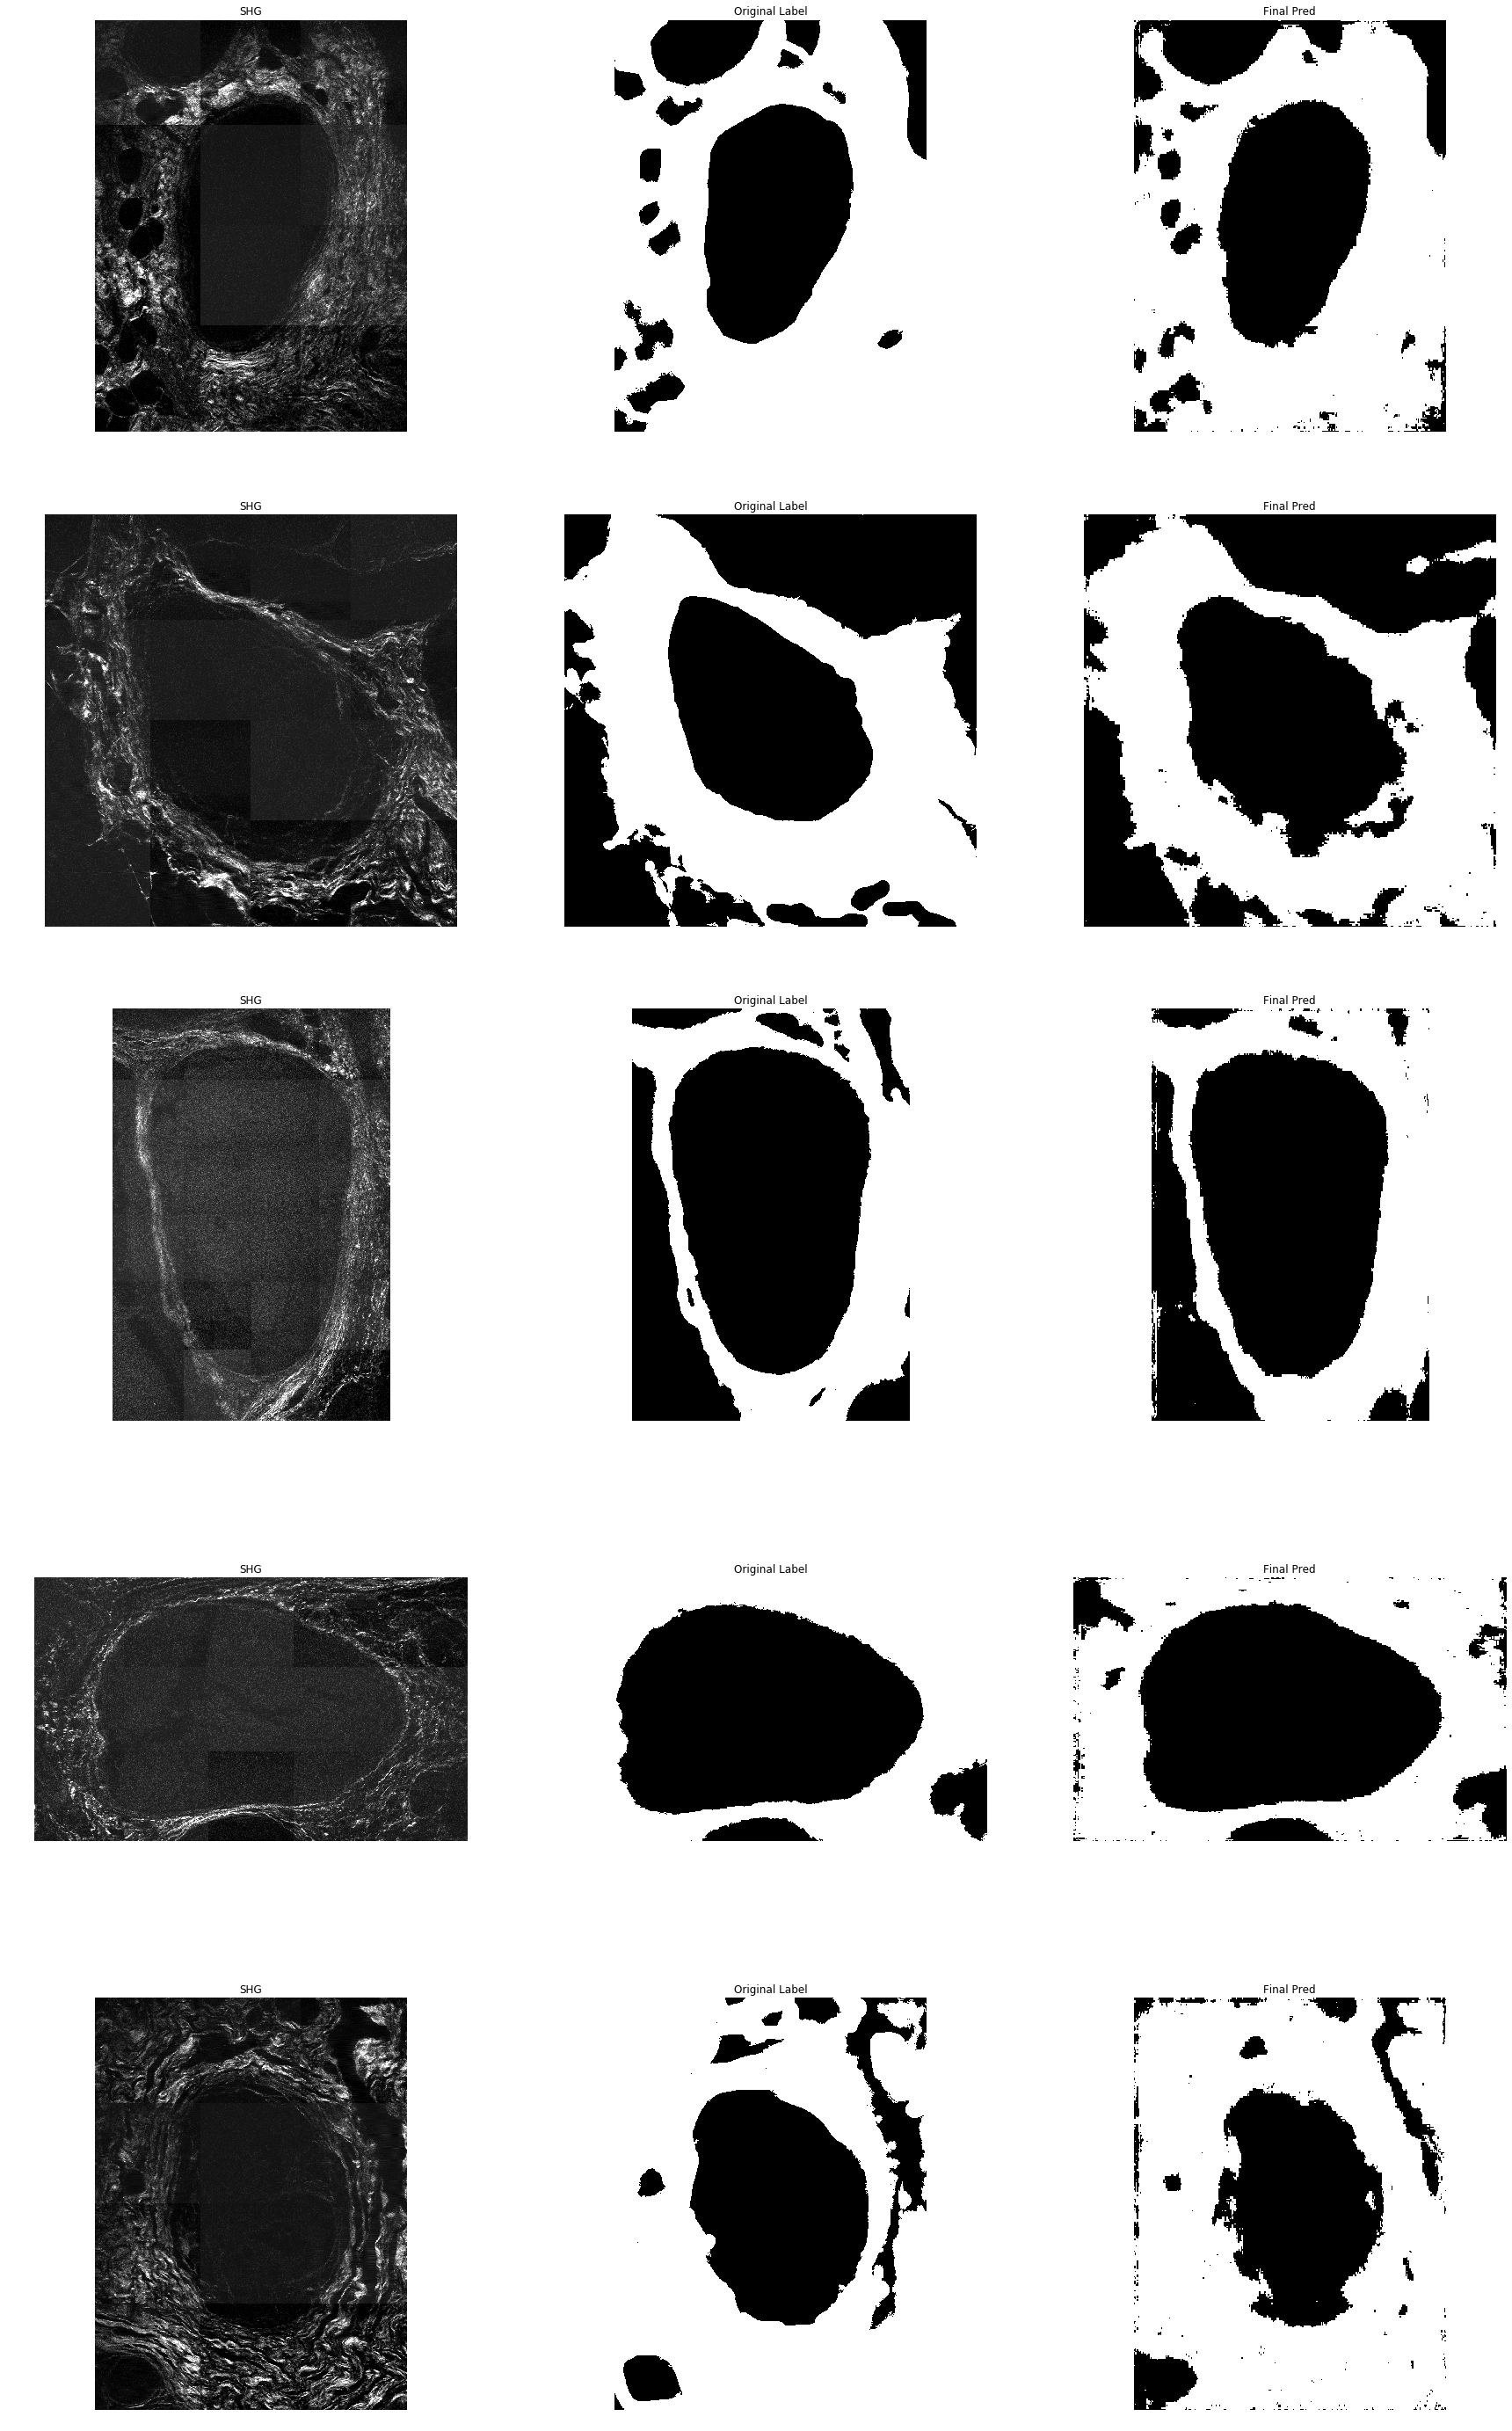

In [176]:
fig = _plot_test(len(fnames))

In [183]:
IMGPATH = EXPERIMENT/"test_results.png"
fig.savefig(IMGPATH)

### fin